In [38]:
import pickle
import glob
import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from typing import List, Union, Any, Tuple
from collections import OrderedDict

# Helper functions

In [62]:
def get_batchsize(path: str) -> int:
    """Extract max batch size from filename"""
    fname = path.split("/")[-1]
    try:
        return int(fname.split("_")[4])
    except ValueError:
        return int(fname.split("_")[4][:-4])

def get_replicas(path: str) -> int:
    """Extract nb of replicas/workers from filename"""
    fname = path.split("/")[-1]
    return int(fname.split("_")[2])


def read_runtimes(folder: str, batch_sizes: List[int], workers: range) -> List[List[List[float]]]:
    """
    Returns the experimental data organised as follows:

        - The top level list contains a `N` sublists. For each of `N` sub-lists the batch size is the same
        - Each of the sub-lists contains `K` elements: each of them corresponds to a different number of replicas
        - Each element of the sub-lists is a list of runtimes. The len corresponding to the number of experimental runs
        for each batch size and workers number combination.
     """

    fname_lists = filter_filenames(folder, workers, batch_sizes)

    # Load data in memory
    runtimes = []
    for lst in fname_lists:
        matching_files = []
        for exp_setting in lst:
            with open(exp_setting, 'rb') as f:
                matching_files.append(pickle.load(f)['t_elapsed'])
        runtimes.append(matching_files)

    return runtimes


def filter_filenames(folder: str, workers_range: range, batch_sizes: List[int]) -> List[List[str]]:
    """
    Return the filenames from `folder` for specified `batch_sizes`, `cpu_range`. The response:

        - Contains ``len(batch_sizes)`` sub-lists
        - Each sublist contains ``len(list(cpu_range))`` filenames

    Each sublist is sorted by the number of replicas (ascending order).
    """

    fname_lists = [[] for _ in range(len(batch_sizes))]
    batch_size_mapping = {batch_size: i for i, batch_size in enumerate(batch_sizes)}
    for file in glob.glob(f'{folder}/ray_*.pkl'):
        batch_size = get_batchsize(file)
        if batch_size not in batch_size_mapping:
            continue
        ncpu = get_replicas(file)
        if ncpu in workers_range:
            fname_lists[batch_size_mapping[batch_size]].append(file)

    for lst in fname_lists:
        lst.sort(key=get_replicas)

    # pprint.pprint(fname_lists)

    return fname_lists


def get_stats(run: List):
    """
    Calculate average runtime of a given distributed computation setting. The len is the number of runs for the
    particular batch_size/nb of workers combination.
    """

    avg = sum(run) / len(run)
    std = np.std(run)

    return avg, std


def extract_timeseries(experiments: List[List[List[float]]], decimals: int = 3) -> Tuple[List[List[Union[float, Any]]], List[List[np.ndarray]]]:
    """
    Extract time series of average runtime timeseries. See `read_runtime` for `experiments` structure. The means and
    standard deviations output are organised as follows:

        - Each entry in the top level list corresponds to a fixed batch size
        - Each entry in the sub-lists corresponds to a different number of workers
    """

    means, stds = [], []  # each sublist is a different batch size
    for batch_size in experiments:
        tmp_mean, tmp_std = [], []  # runtime for same batch, different number of workers
        for workers in batch_size:
            mu, sigma = get_stats(workers)
            tmp_mean.append(mu)
            tmp_std.append(sigma)
        means.append(np.around(tmp_mean, decimals=decimals))
        stds.append(np.around(tmp_std, decimals=decimals))

    return means, stds


def compare_timing(means, stds, labels, cpu_range, bar_width=0.1, y_min=0, y_max=34.0, y_step=0.5,
                   legend_pos=(1.24, -0.09), yticks_fontsize=20, figsize=None, logy=False, ncol=1,
                   show_baseline=False):
    fig, ax = plt.subplots(figsize=figsize)

    bar_positions = np.array(np.arange(1, len(list(cpu_range)) + 1))
    if show_baseline:
        baseline_x = np.array(np.arange(bar_positions[0]-0.5, bar_positions[-1]+ 0.5 + bar_positions[1] - bar_positions[0]))
        ax.errorbar(baseline_x, 
                    [baseline_mean_time]*len(baseline_x), 
                    yerr=baseline_std_time,
                    fmt='r--')
    xticks = [str(x) for x in cpu_range]
    bps = []
    with sns.axes_style("white"):
        sns.set_style("ticks")
        sns.set_context("talk")
        for m, s, label in zip(means, stds, labels):
            print(label)
            if len(m.shape) == 2:
                m = m.squeeze()
                s = s.squeeze()
            bar_plot = ax.bar(bar_positions,
                              m,
                              bar_width,
                              yerr=s,
                              label=label,
                              capsize=10
                              )
            bps.append(bar_plot)
            bar_positions = bar_positions + bar_width
        
        ax.set_xlabel(r'workers', fontsize=30)
        ax.set_xticks(bar_positions - 2 * bar_width)
        ax.set_xticklabels(xticks, rotation=45, fontsize=25)

        ax.set_ylabel('Time (s)', fontsize=30)
        if logy:
            ax.set_yscale('log')
        else:
            ax.set_ylim(top=y_max)
            ax.set_ylim(bottom=y_min)
            y_ticks = np.arange(y_min, y_max, y_step)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_ticks, fontsize=yticks_fontsize)

            

        ax.grid(True)#, which='both')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), ncol=ncol, fontsize=20)
        sns.despine()

    return ax, bps

def autolabel(ax, rects, stdevs, fontsize=20, rotation=90, v_offset=3):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect, s in zip(rects, stdevs):
        height = rect.get_height() + s
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, v_offset),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontsize=fontsize, 
                    rotation=rotation)


# Data download

If you have not installed `gsutil` run the following commands in your terminal:

* `curl https://sdk.cloud.google.com | bash`
* `exec -l $SHELL`
* `gcloud init`

and restart your terminal to see the changes.

## Ray Actor Pool (1 machine)

In [ ]:
!mkdir -p results/ray_actor_pool_benchmark/
!gsutil -m cp -r gs://sedon-experiments/distributed_kernel_shap/ray_actor_pool_benchmark results

## Ray Serve (1 machine)

In [ ]:
!mkdir -p results/ray_serve_benchmark/ 
!gsutil -m cp -r gs://sedon-experiments/distributed_kernel_shap/ray_serve_benchmark results

## Ray Actor Pool (k8s)

In [ ]:
!mkdir -p results/k8s_ray_actor_pool_benchmark 
!gsutil -m cp -r gs://sedon-experiments/distributed_kernel_shap/k8s_ray_actor_pool_benchmark results

## Ray Serve (k8s): ray_minibatch

In [ ]:
!mkdir -p results/k8s_ray_serve_benchmark_raybatch
!gsutil -m cp -r gs://sedon-experiments/distributed_kernel_shap/k8s_ray_serve_benchmark_raybatch results

## Ray Serve (k8s): minibatch_requests

In [ ]:
!mkdir -p results/k8s_ray_serve_benchmark_minibatch
!gsutil -m cp -r gs://sedon-experiments/distributed_kernel_shap/k8s_ray_serve_benchmark_minibatch results

# Task

The benchmarking task consists of explaining `2560` predictions of a logistic regression model fitted to the `Adult` dataset using KernelSHAP configured with `100` background samples. 

# Computational Resources

**Single node:** Digital Ocean, compute-optimised dedicated CPU with 32 vCPUs.

**Cluster**: two instances of the above (total usable resource 56 vCPUs)

# Results

## Without using ray

In [45]:
with open('results/sequential.pkl', 'rb') as f:
    times = pickle.load(f)

In [46]:
print(f"Average time {np.mean(times)} with standard deviation {np.std(times)}")
baseline_mean_time = np.mean(times)
baseline_std_time = np.std(times)

Average time 1736.8916582918087 with standard deviation 6.743651970126239


## Single node computation

### Ray Actor Pool 

In [63]:
batch_sizes = [1, 5, 10]
replicas_range = [1] + list(range(2, 34, 2))

folder = 'results/ray_actor_pool_benchmark/'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


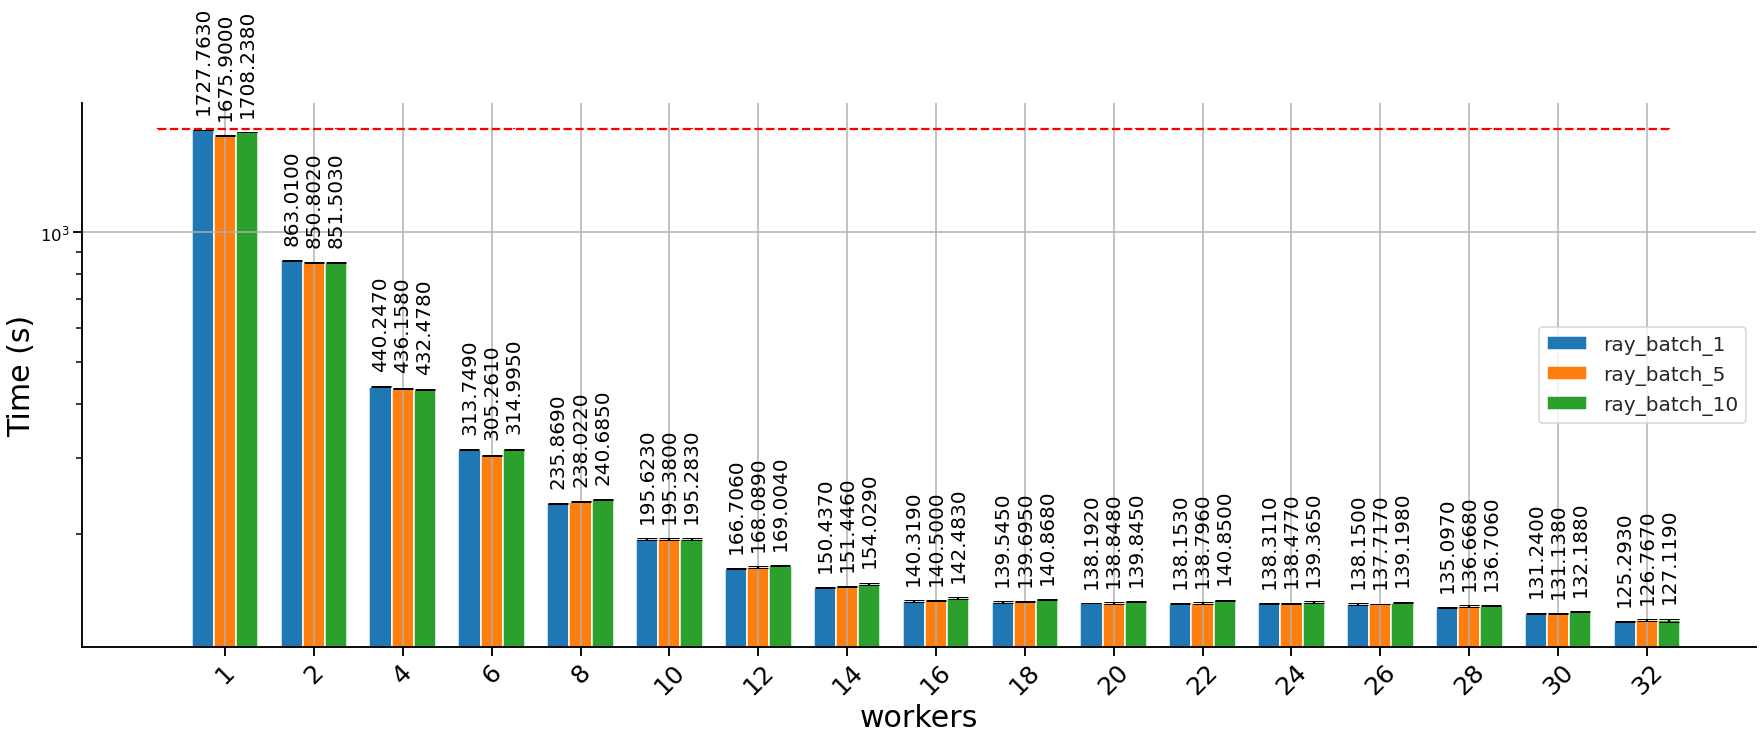

In [64]:
y_max = 10000
y_step = 100
figsize = (30, 10)
bar_width = 0.25
logy, show_baseline = True, True
ax, bps = compare_timing(avg_runtime, 
                         runtime_std, 
                         labels, 
                         replicas_range, 
                         bar_width=bar_width, 
                         y_max=y_max, 
                         y_step=y_step, 
                         figsize=figsize, 
                         logy=logy,
                         show_baseline=show_baseline
                        )
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=15)

Observations:

- Fastest run: 125.05s (vs 1736.89) which is approx 14x faster
- Batching 5 explanations together brings some benefit when there are few workers executing the task (?)
- Note that the explainer does not benefit from batching
- No "significant" improvements beyond workers=16 setting (presumably due to the underlying physical architecture)

### Ray Serve 

The results obtained when benchmarking ray serve are presented below for different ranges of CPUS.

In [139]:
batch_sizes = [1, 5, 10]
replicas_range = [1] + list(range(2, 34, 2))

folder = 'results/ray_serve_benchmark'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


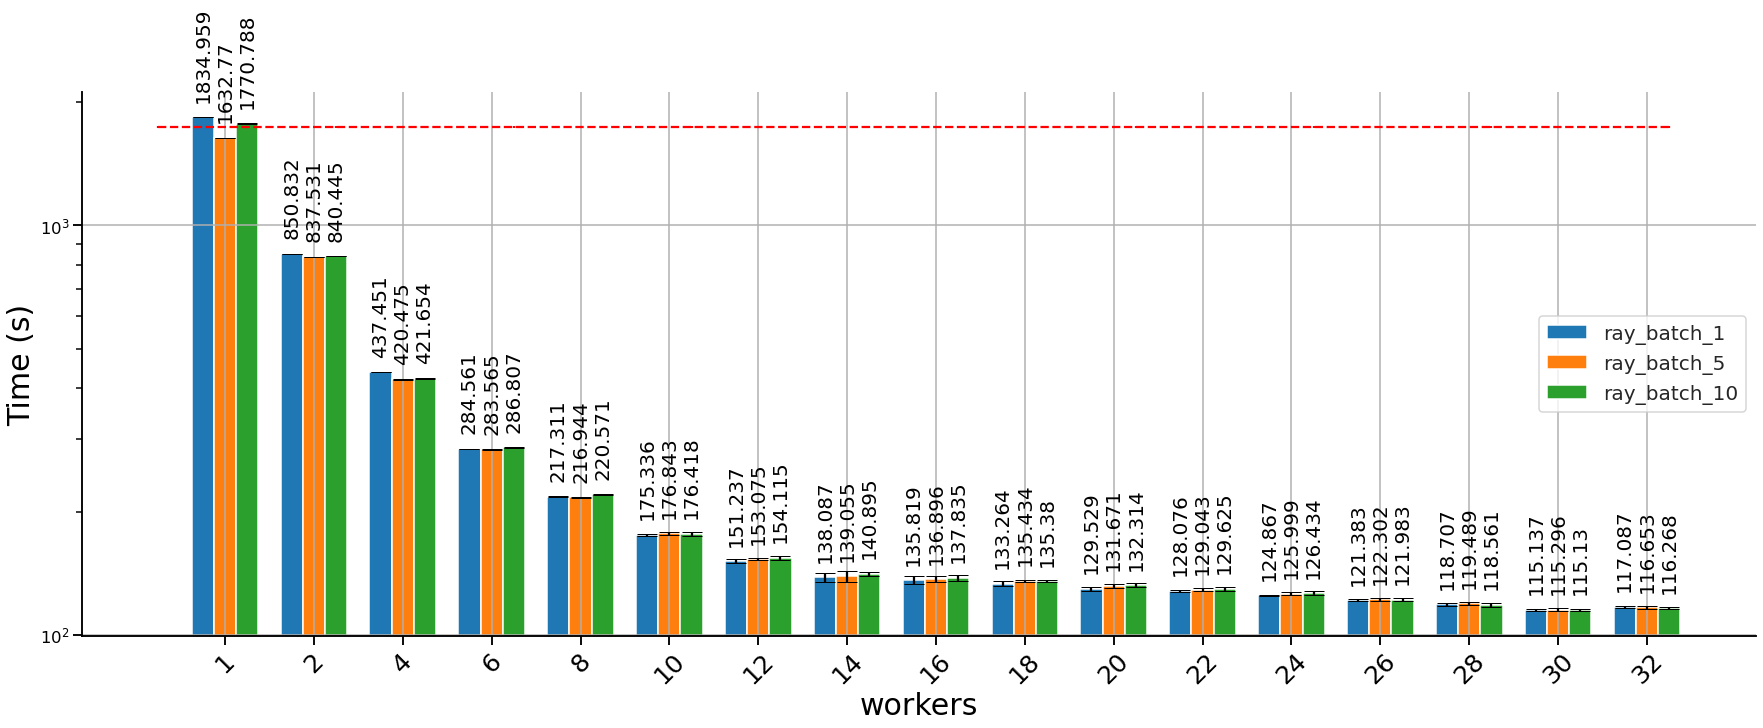

In [140]:
y_max = 1900
y_step = 100
figsize = (30, 10)
bar_width = 0.25

logy, show_baseline = True, True
ax, bps = compare_timing(avg_runtime, 
                         runtime_std, 
                         labels, 
                         replicas_range, 
                         bar_width=bar_width, 
                         y_max=y_max, 
                         y_step=y_step, 
                         figsize=figsize, 
                         logy=logy,
                         show_baseline=show_baseline
                        )
for bp in bps:
    autolabel(ax, bp, fontsize=20, v_offset=15)

Observations:

- Fastest time is 115.13 (vs 1736.89), approx 15x improvement. 
- Similar behaviours of batching for small number of workers 
- Not much improvement once the physical core limit is exceeded

## Multi-node setup with k8s

### Ray Actor Pool

#### CPU RANGE: 2:34:2

In [10]:
batch_sizes = [1,5, 10]
replicas_range = [1] + list(range(2, 34, 2))
folder = 'results/k8s_ray_actor_pool_benchmark'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


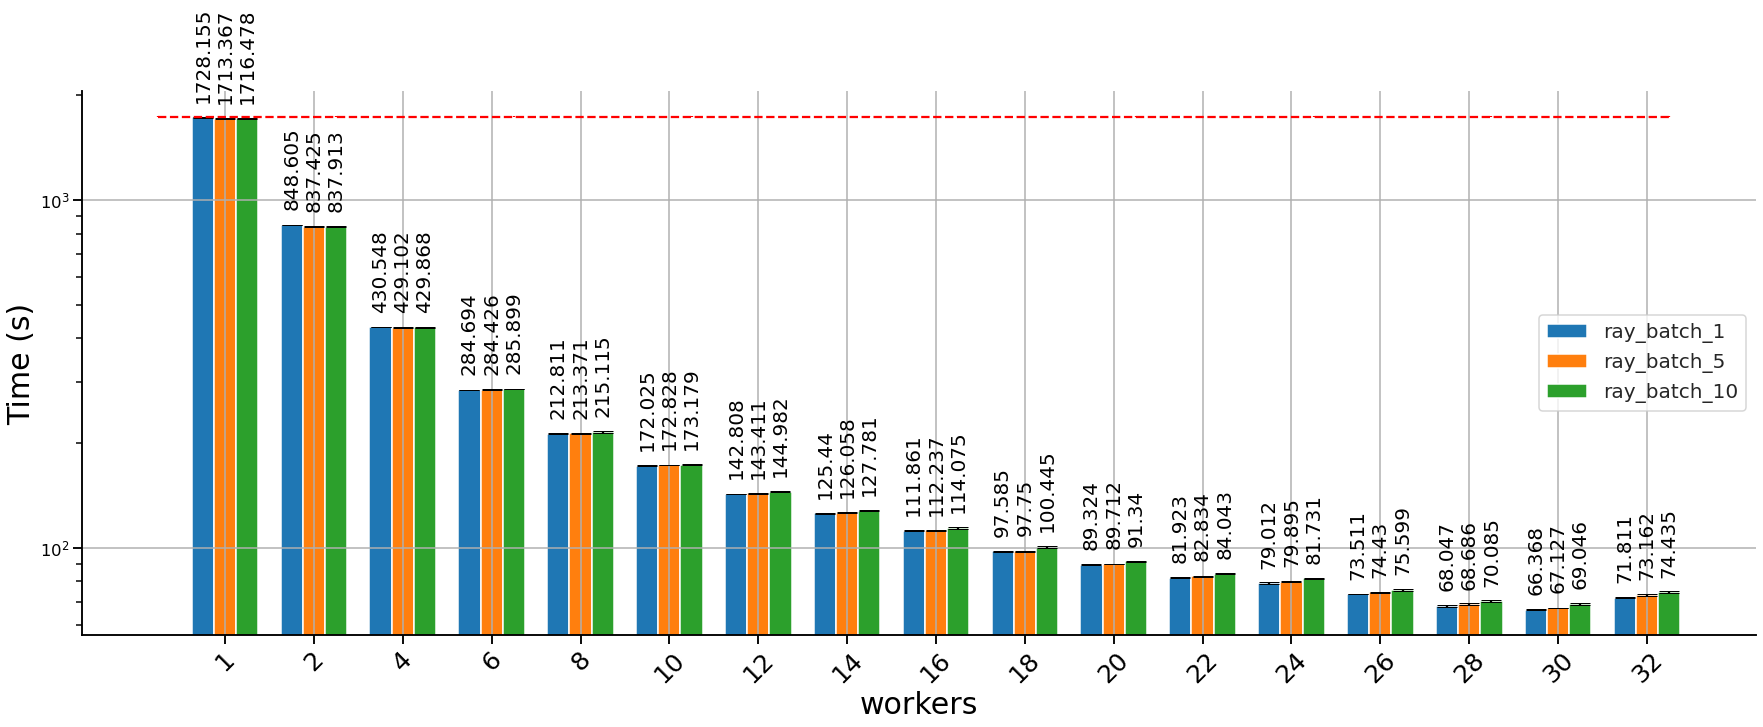

In [15]:
y_max = 1800
y_step = 100
figsize = (30, 10)
bar_width = 0.25


logy, show_baseline = True, True
ax, bps = compare_timing(avg_runtime, 
                         runtime_std, 
                         labels, 
                         replicas_range, 
                         bar_width=bar_width, 
                         y_max=y_max, 
                         y_step=y_step, 
                         figsize=figsize, 
                         logy=logy,
                         show_baseline=show_baseline
                        )
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=15)

#### CPU RANGE:  32:56:2

In [66]:
batch_sizes = [1,5, 10]
replicas_range = list(range(32, 58, 2))
folder = 'results/k8s_ray_actor_pool_benchmark'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


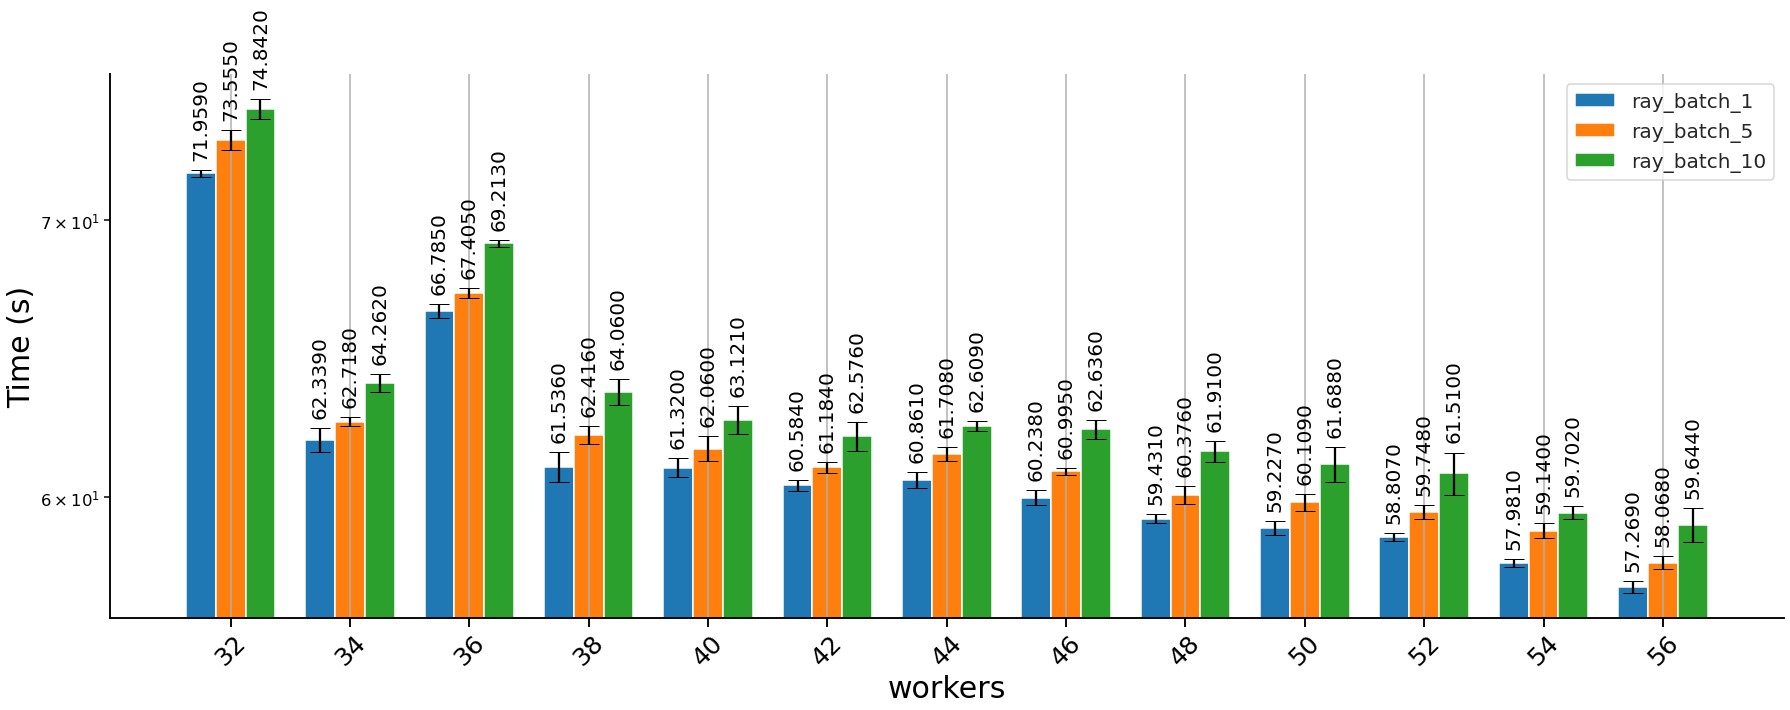

In [68]:
y_max = 150
y_min = 0
y_step = 100
figsize = (30, 10)
logy=True
bar_width = 0.25


ax, bps = compare_timing(avg_runtime, runtime_std, labels, replicas_range, y_max=y_max, y_step=y_step, figsize=figsize, bar_width=bar_width, logy=logy)
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=10)

### Ray serve (distributed minibatches)

#### CPU RANGE: 2:34:2

In [69]:
batch_sizes = [1,5, 10]
replicas_range = [1] + list(range(2, 34, 2))
folder = 'results/k8s_ray_serve_benchmark_minibatch/'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


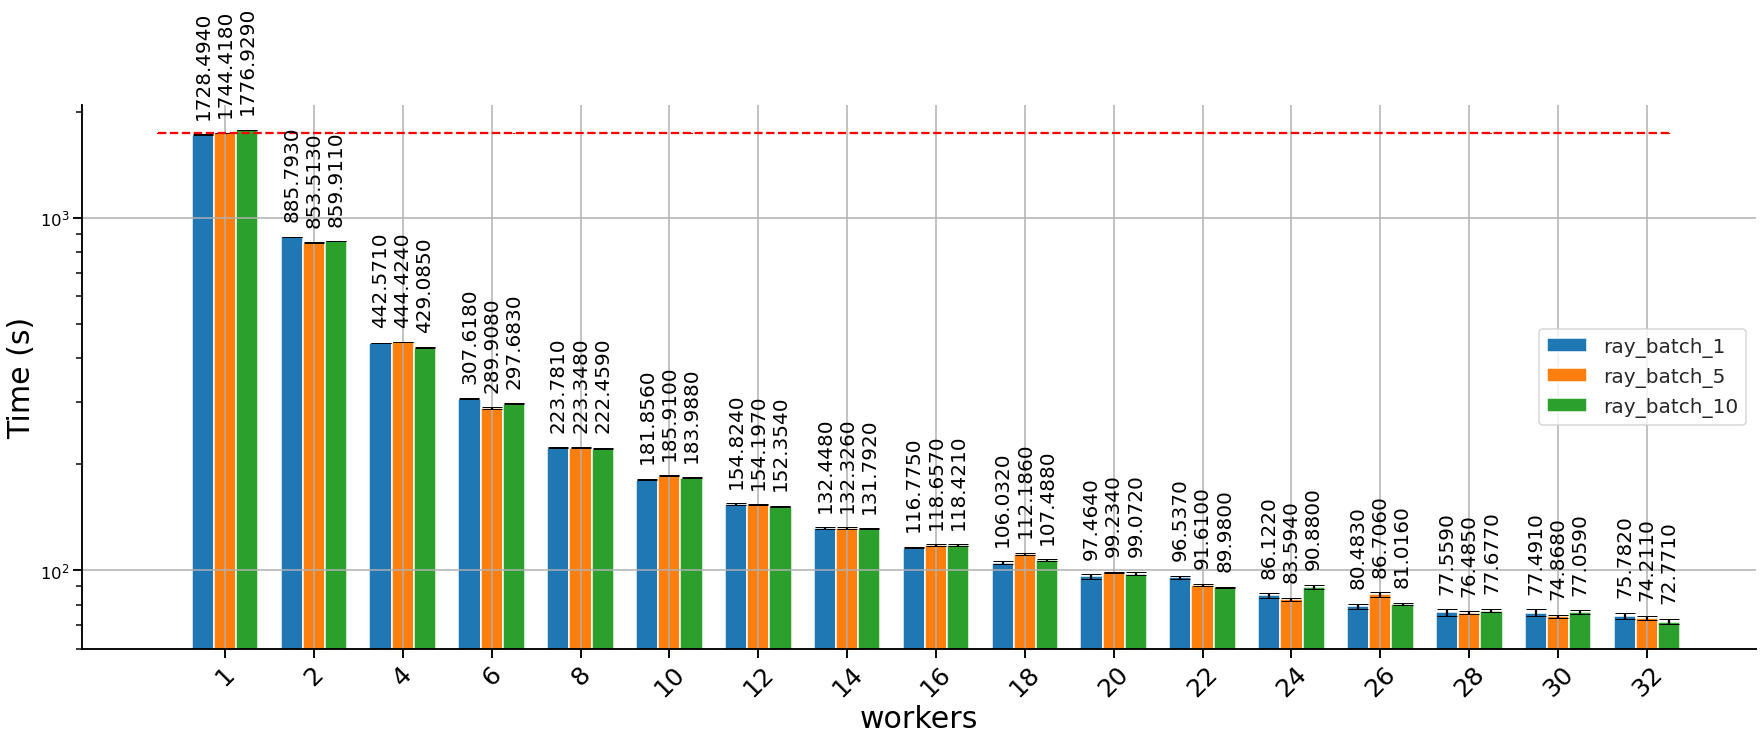

In [72]:
y_max = 1900
y_step = 100
figsize = (30, 10)

bar_width = 0.25

logy, show_baseline = True, True
ax, bps = compare_timing(avg_runtime, 
                         runtime_std, 
                         labels, 
                         replicas_range, 
                         bar_width=bar_width, 
                         y_max=y_max, 
                         y_step=y_step, 
                         figsize=figsize, 
                         logy=logy,
                         show_baseline=show_baseline
                        )

for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=15)

#### CPU RANGE: 34:58:2

In [73]:
batch_sizes = [1,5, 10]
replicas_range =  list(range(32, 58, 2))
folder = 'results/k8s_ray_serve_benchmark_minibatch/'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


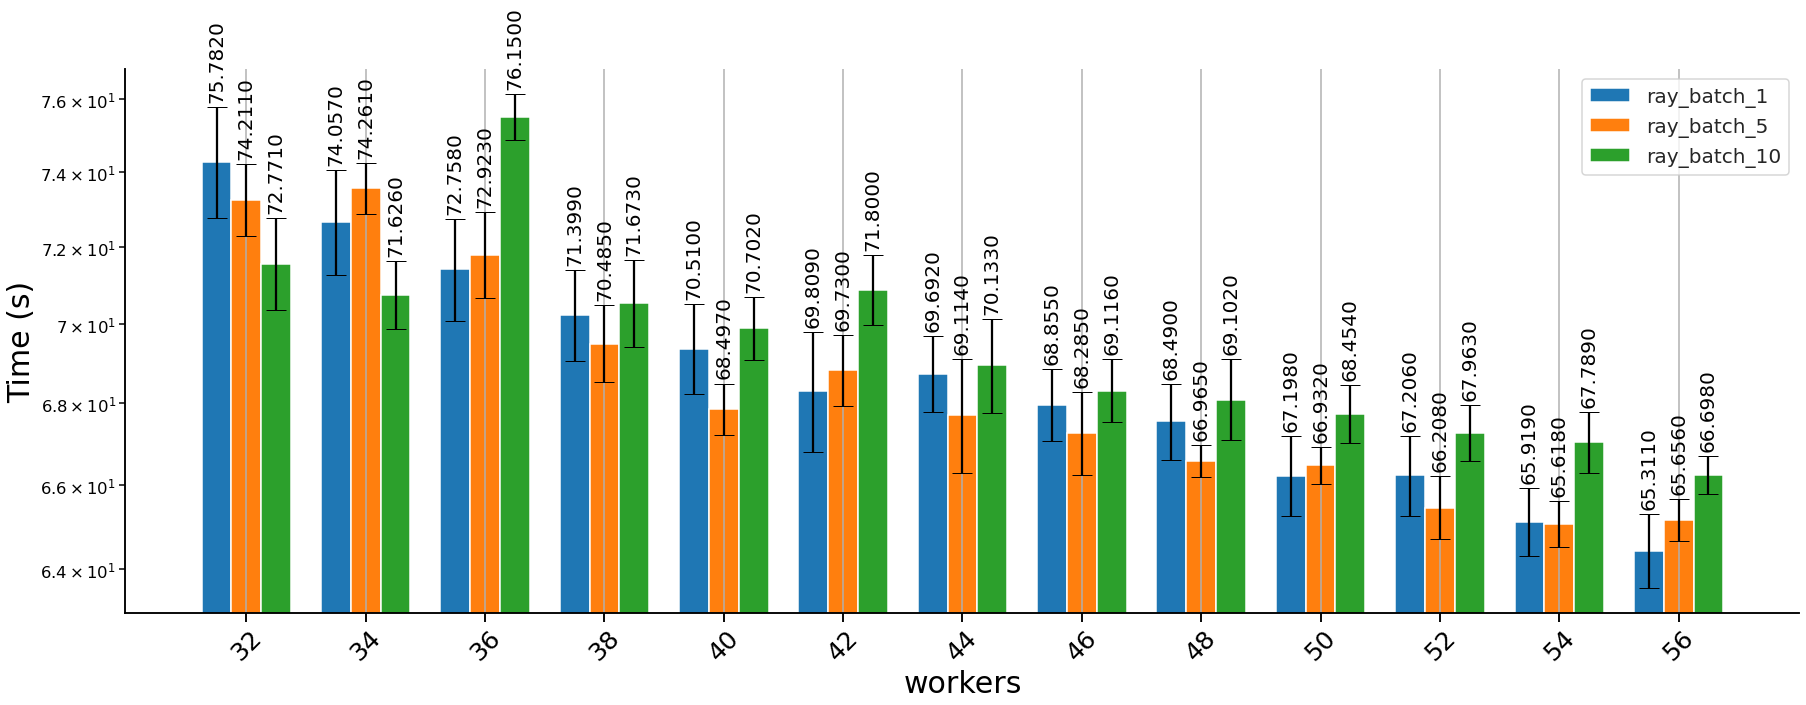

In [75]:
y_max = 150
y_min = 0
y_step = 100
figsize = (30, 10)
logy=True
bar_width = 0.25


ax, bps = compare_timing(avg_runtime, runtime_std, labels, replicas_range, y_max=y_max, y_step=y_step, figsize=figsize, bar_width=bar_width, logy=logy)
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=5)

### Ray serve (ray minibatch)

#### CPU RANGE: 2:34:2

In [77]:
batch_sizes = [1,5, 10]
replicas_range = [1] + list(range(2, 34, 2))
folder = 'results/k8s_ray_serve_benchmark_raybatch/'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


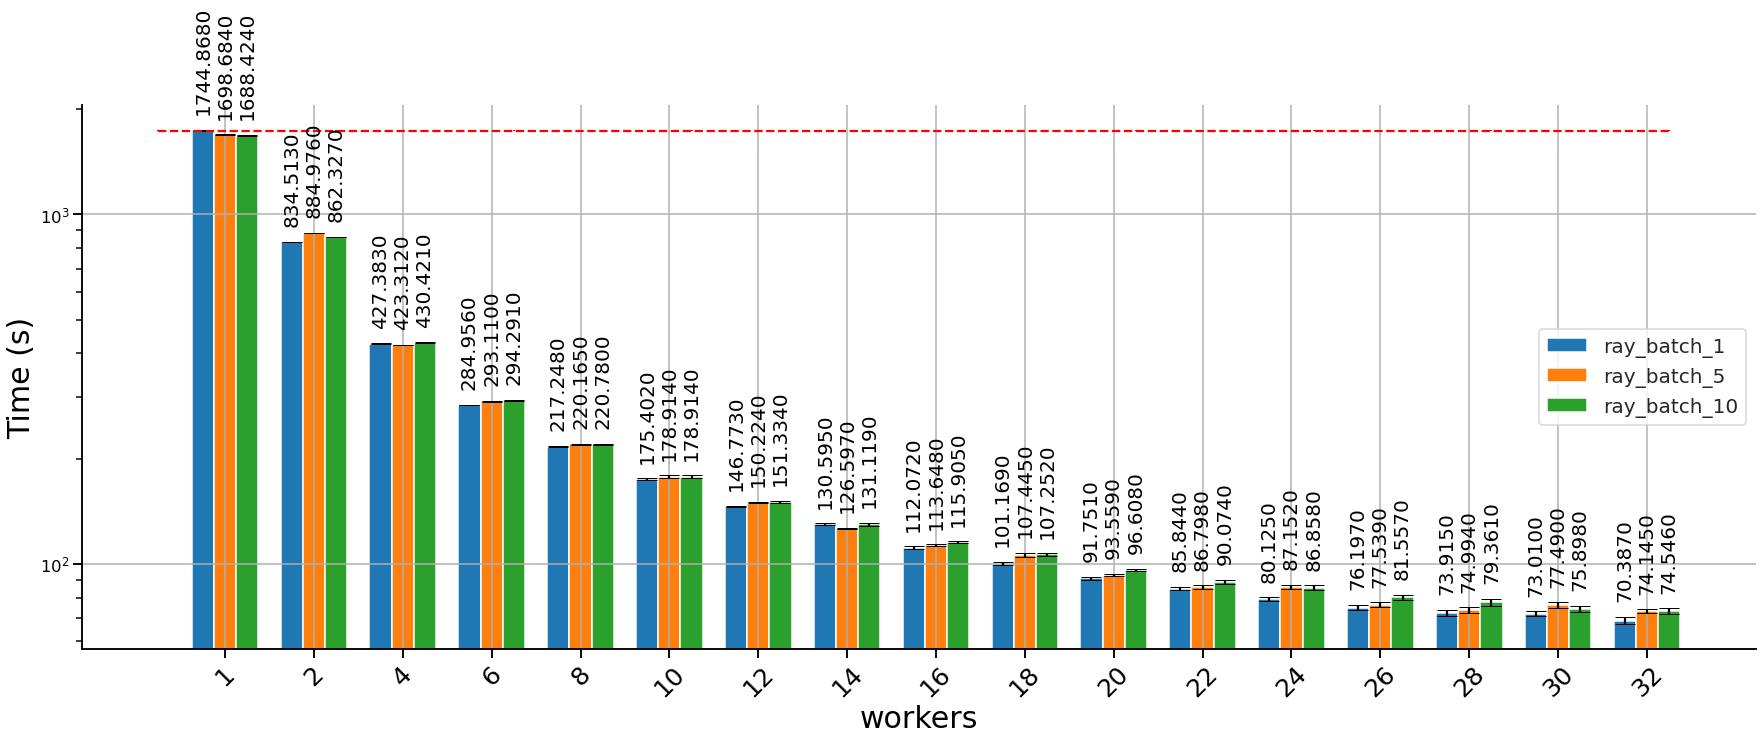

In [78]:
y_max = 1900
y_step = 100
figsize = (30, 10)
bar_width = 0.25


logy, show_baseline = True, True
ax, bps = compare_timing(avg_runtime, 
                         runtime_std, 
                         labels, 
                         replicas_range, 
                         bar_width=bar_width, 
                         y_max=y_max, 
                         y_step=y_step, 
                         figsize=figsize, 
                         logy=logy,
                         show_baseline=show_baseline
                        )
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=15)

#### CPU RANGE: 34:58:2

In [79]:
batch_sizes = [1,5, 10]
replicas_range = list(range(34, 58, 2))
folder = 'results/k8s_ray_serve_benchmark_raybatch/'
labels = ['ray_batch_{}'.format(size) for size in batch_sizes]
runtimes = read_runtimes(folder, batch_sizes, replicas_range)
avg_runtime, runtime_std = extract_timeseries(runtimes, decimals=3)

ray_batch_1
ray_batch_5
ray_batch_10


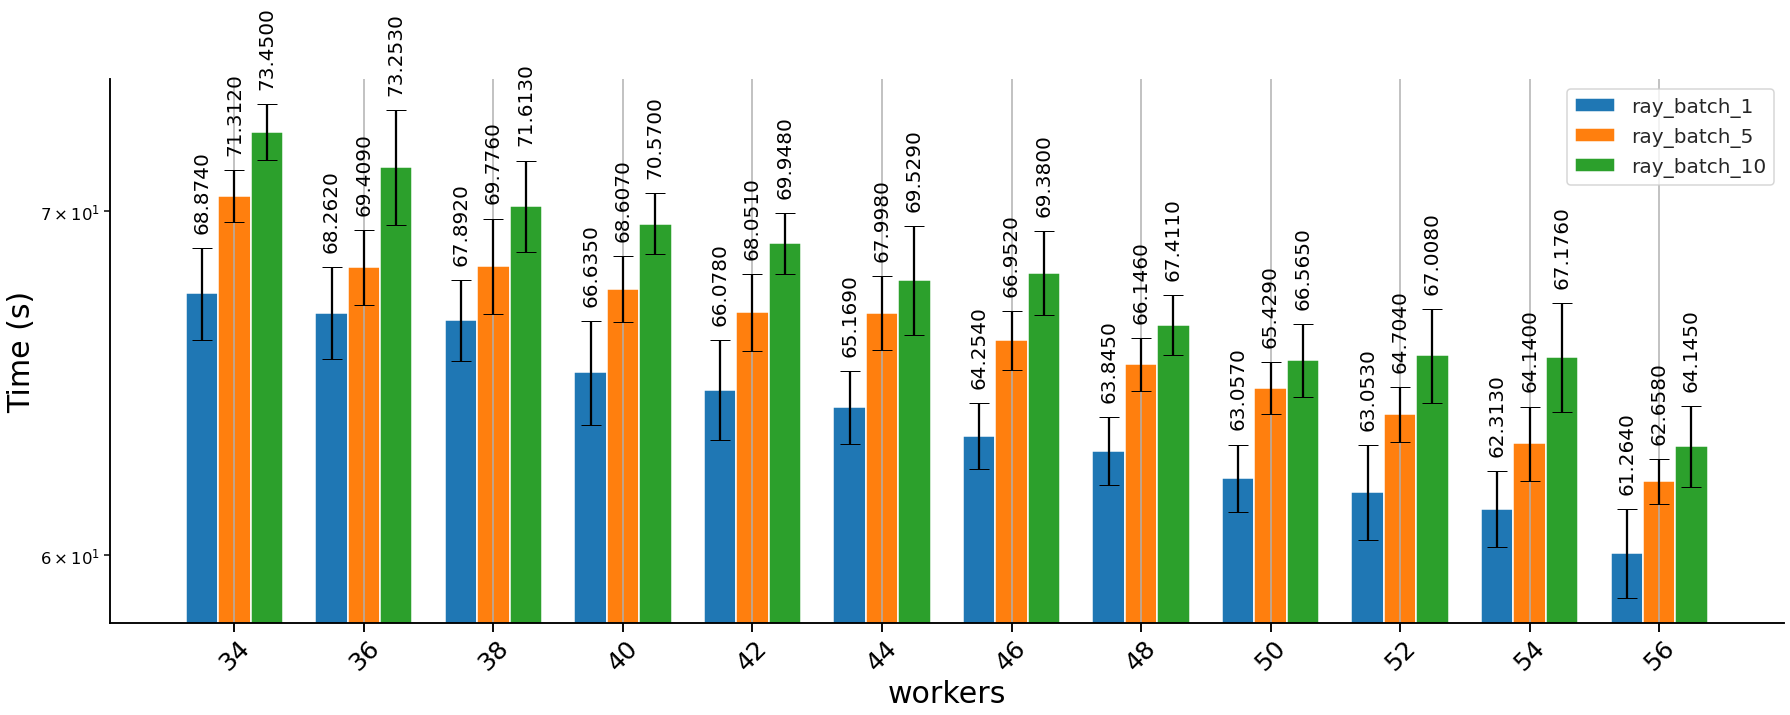

In [80]:
y_max = 150
y_min = 0
y_step = 100
figsize = (30, 10)
logy=True
bar_width = 0.25


ax, bps = compare_timing(avg_runtime, runtime_std, labels, replicas_range, y_max=y_max, y_step=y_step, figsize=figsize, bar_width=bar_width, logy=logy)
for bp, std in zip(bps, runtime_std):
    autolabel(ax, bp, std, fontsize=20, v_offset=15)

# Sanity check

In [ ]:
with open('results/ray_replicas_3_maxbatch_1.pkl', 'rb') as f:
    times = pickle.load(f)['t_elapsed']
print(np.mean(times))